In [1]:
#Importing relevant packages and King county data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import itertools
from numbers import Number
from scipy import stats
import statsmodels.api as sm
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
%matplotlib inline


df = pd.read_csv("data/kc_house_data.csv",parse_dates=['date'], index_col=0)

In [2]:
#Dropping columns that were suggested not to use, except date and zipcode
df.drop(['view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)


In [3]:
#Creating price per square foot column
df['price_sqft'] = df['price'] / df['sqft_living']

In [4]:
#Creating map for zipcodes
zip_map = {
    98001:'Suburbs', 98002:'Suburbs', 98003:'Suburbs', 98004:'Suburbs', 98005:'Suburbs',
    98006:'Suburbs', 98007:'Suburbs',98008:'Suburbs', 98010:'Rural', 98011:'Suburbs', 
    98014:'Rural', 98019:'Rural', 98022:'Rural', 98023:'Suburbs', 98024:'Rural', 
    98027:'Rural', 98028:'Suburbs', 98029:'Suburbs', 98030:'Suburbs', 98031:'Suburbs',
    98032:'Suburbs', 98033:'Suburbs', 98034:'Suburbs', 98038:'Rural', 98039:'Suburbs',
    98040:'Suburbs', 98042:'Rural', 98045:'Rural', 98052:'Suburbs', 98053:'Rural',
    98055:'Suburbs', 98056:'Suburbs', 98058:'Suburbs', 98059:'Suburbs', 98065:'Rural',
    98070:'Suburbs', 98072:'Suburbs', 98074:'Suburbs', 98075:'Suburbs', 98077:'Rural',
    98092:'Suburbs', 98102:'Seattle', 98103:'Seattle', 98105:'Seattle', 98106:'Seattle',
    98107:'Seattle', 98108:'Seattle', 98109:'Seattle', 98112:'Seattle', 98115:'Seattle', 
    98116:'Seattle', 98117:'Seattle', 98118:'Seattle', 98119:'Seattle', 98122:'Seattle',
    98125:'Seattle', 98126:'Seattle', 98133:'Seattle', 98136:'Seattle', 98144:'Seattle', 
    98146:'Seattle', 98148:'Seattle', 98155:'Seattle', 98166:'Seattle', 98168:'Seattle',
    98177:'Seattle', 98178:'Seattle', 98188:'Seattle', 98198:'Seattle', 98199:'Seattle'
    }

df['zones'] = df['zipcode'].map(zip_map)

Sorted zipcodes with following sources
- website =  https://www.unitedstateszipcodes.org/wa/ 
- map = https://aqua.kingcounty.gov/gis/web/VMC/boundaries/zipcodes/zipcodes.pdf

In [5]:
#creating a map for condition since there are low values of Poor and Fair compared to the other categorical variables
condition_map = {'Poor': 'Below Average',
                 'Fair': 'Below Average',
                 'Average': 'Average',
                 'Good': 'Above Average',
                 'Very Good': 'Exceeds Average',
                }

#adding to df
df['cond_cat'] = df['condition'].map(condition_map)

In [6]:
#mapping grade column
grade_map = {'3 Poor': 'Below Average',
             '4 Low': 'Below Average',
             '5 Fair': 'Below Average',
             '6 Low Average': 'Below Average',
             '7 Average': 'Average',
             '8 Good': 'Above Average',
             '9 Better': 'Above Average',
             '10 Very Good': 'Exceeds Average',
             '11 Excellent': 'Exceeds Average',
             '12 Luxury': 'Other',
             '13 Mansion': 'Other'}

#adding to df
df['grade_cat'] = df['grade'].map(grade_map)

In [7]:
#Dropping columns we mapped and created new columns for
df.drop(['condition', 'grade', 'zipcode'], axis=1, inplace=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,yr_built,price_sqft,zones,cond_cat,grade_cat
id,,,,,,,,,,,,,
7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,1955,188.050847,Seattle,Average,Average
6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,1951,209.338521,Seattle,Average,Average
5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,1933,233.766234,Suburbs,Average,Below Average
2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,1965,308.163265,Seattle,Exceeds Average,Average
1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,1987,303.571429,Suburbs,Average,Above Average


# -- Modeling portion


In [8]:
#defining X & y
X = df.drop(columns='price', axis=1)
y = df['price']

In [9]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
#creating a train df and test df
train_kch = pd.concat([X_train, y_train], axis=1)
test_kch = pd.concat([X_test, y_test], axis=1)


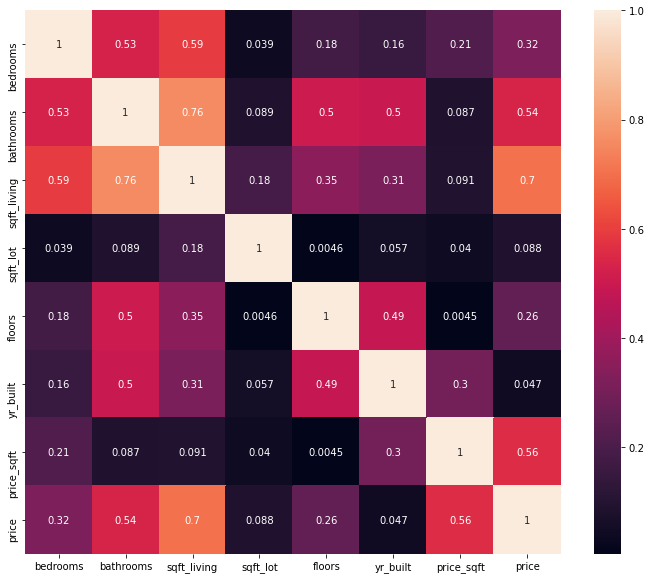

In [11]:
#heatmap to understand data better
plt.figure(figsize=(12,10))
sns.heatmap(train_kch.corr().abs(), annot=True)
plt.show()

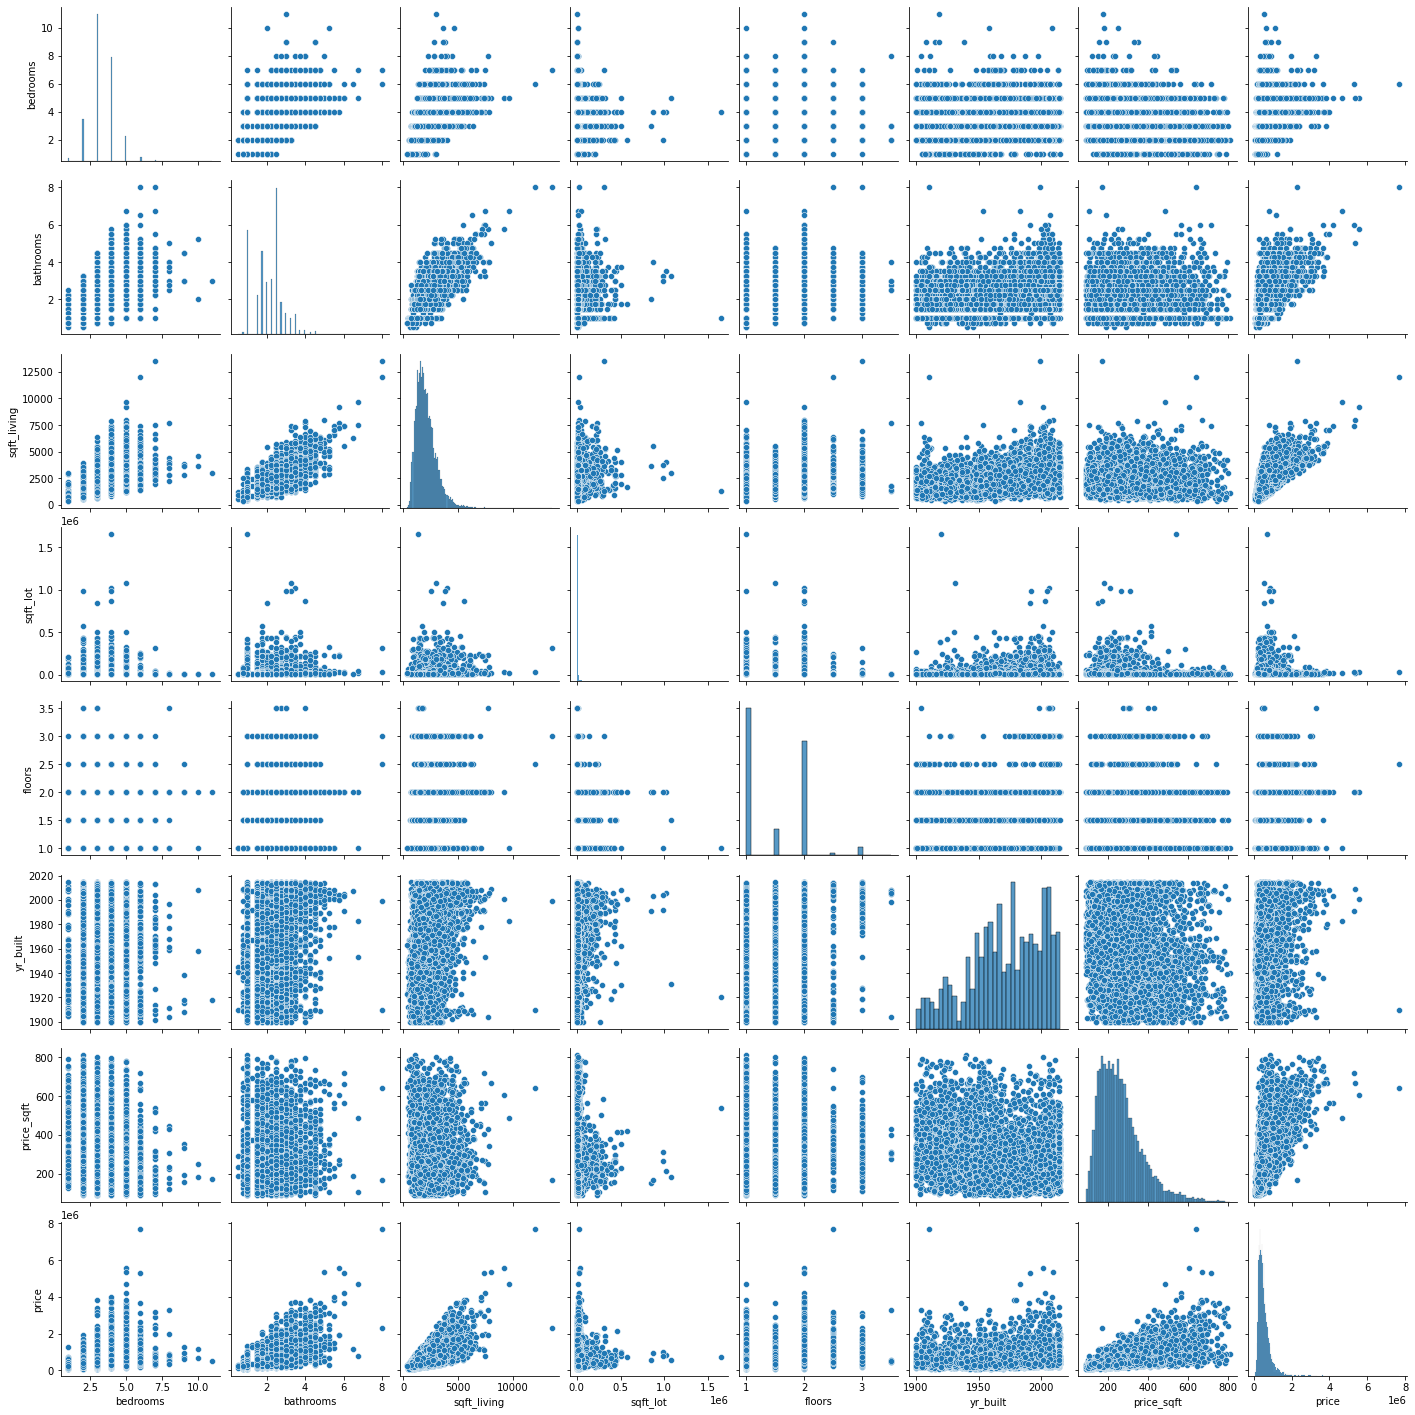

In [12]:
#Pairplot to understand data better
sns.pairplot(train_kch)
plt.show()

In [13]:
df.corr()['sqft_living']

price          0.701917
bedrooms       0.578212
bathrooms      0.755758
sqft_living    1.000000
sqft_lot       0.173453
floors         0.353953
yr_built       0.318152
price_sqft    -0.091167
Name: sqft_living, dtype: float64

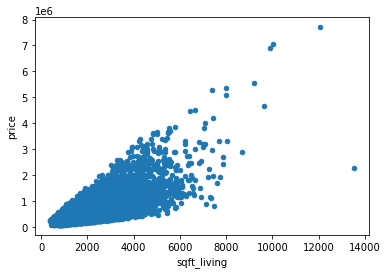

In [14]:
df.plot.scatter(x='sqft_living', y='price');

In [17]:
results = sm.OLS(df['sqft_living'], sm.add_constant(df[["price"]])).fit()
results.params

const    1132.537450
price       0.001754
dtype: float64

In [18]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sqft_living   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Mon, 12 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:31:45   Log-Likelihood:            -1.7066e+05
No. Observations:               21597   AIC:                         3.413e+05
Df Residuals:                   21595   BIC:                         3.413e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1132.5374      7.914    143.104      0.000    1117.025    1148.050
price          0.0018   1.21e-05    144.819      0.000       0.002       0.002
==============================================================================
Omnibus:                     2829.055   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8794.373
Skew:                           0.685   Prob(JB):                         0.00
Kurtosis:                       5.810   Cond. No.                     1.16e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""